# k-Nearest Neighbor (kNN) exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

The kNN classifier consists of two stages:

- During training, the classifier takes the training data and simply remembers it
- During testing, kNN classifies every test image by comparing to all training images and transfering the labels of the k most similar training examples
- The value of k is cross-validated

In this exercise you will implement these steps and understand the basic Image Classification pipeline, cross-validation, and gain proficiency in writing efficient, vectorized code.

kNN classifier는 두 단계로 이루어져 있다.
- 학습중에는 training data를 가져다가 단순히 기억해둔다
- 테스트 중에는 모든 테스트 이미지들을 모든 training data(=학습 이미지 + 라벨)과 비교한 다음 가장 비슷한 k개의 이미지들을 전달해준다
- k의 값은 cross-validate 된다

In [ ]:
# Run some setup code for this notebook.

import random
import numpy as np  # 데이터 다루는데 용이한 라이브러리
from cs231n.data_utils import load_CIFAR10  # CIFAR10 데이터를 가져오기 위해서 cs231n 강좌에서 만들어준 함수
import matplotlib.pyplot as plt  # 도표 만들어주는 라이브러리

# This is a bit of magic to make matplotlib figures appear inline in the notebook
# rather than in a new window.
# 이걸 먹여주면 다른 창이 아니라 여기서 바로 도표를 볼 수 있다. 아래는 도표관련 설정이다
%matplotlib inline  
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
# 아래 두 줄은 무엇을 의미하는가? https://ipython.org/ipython-doc/3/config/extensions/autoreload.html
# 현재 이 셀에서는 cs231n 폴더의 data_utils.py 파일의 load_CIFAR10 함수를 불러다 쓴다. 
# 우리가 data_utils.py의 load_CIFAR10 부분을 고쳤더라도, 여기서 바로 실행하면 실행할때마다 가져오도록 하는 것이다
%load_ext autoreload
%autoreload 2

In [ ]:
# Load the raw CIFAR-10 data.
cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)  # cs231n 강좌에서 편하게 가져올 수 있게 해둠

# As a sanity check, we print out the size of the training and test data.
# python 3에 맞게 print에 괄호 사용해줌. shape는 단순히 배열의 모양을 보여줌. ex) 2*3 
print ('Training data shape: ', X_train.shape)
print ('Training labels shape: ', y_train.shape)
print ('Test data shape: ', X_test.shape)
print ('Test labels shape: ', y_test.shape)

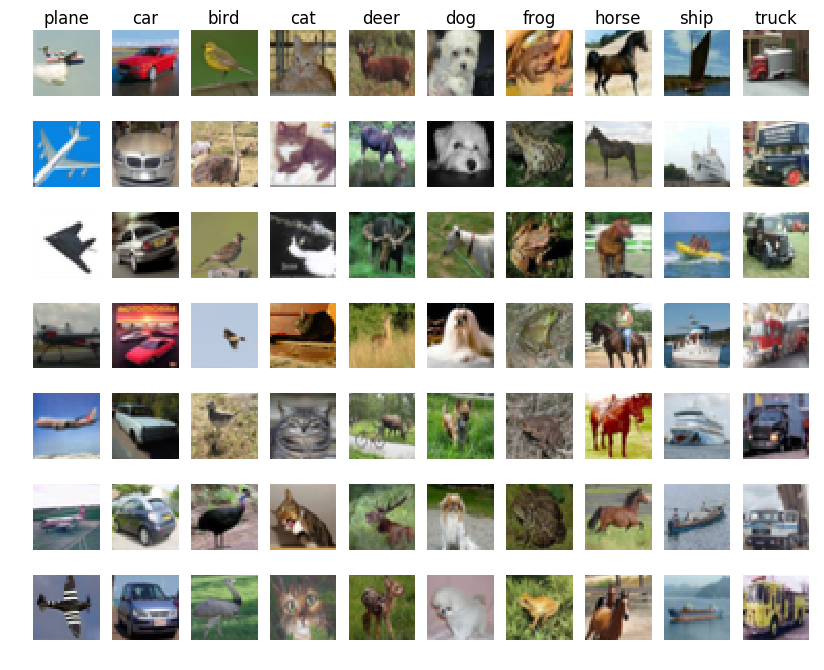

In [96]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
# y_train은 숫자 0-9를 가진다
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):  # enumerate는 각각의 번호를 붙여준다 ex) 'plane' --> (1, 'plane)
    idxs = np.flatnonzero(y_train == y) # 0dl 아닌경우, 즉 True인 경우의 index들을 저장
    
    # idxs들 중에서 7개만 추출, 중복은 없다(replace=False)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)    
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1  # 그림 하나하나들 위치
        plt.subplot(samples_per_class, num_classes, plt_idx)  # 7*10의 구획으로 나누고 칸의 index 지정
        # X_train[]의 이미지들을 뿌려준다. uint8은 0-255 값을 가진다는 의미
        plt.imshow(X_train[idx].astype('uint8')) 
        plt.axis('off')  # 가로 세로 축 삭제
        
        if i == 0:
            plt.title(cls)  # 타이틀을 지우라는 것으로 보이는데, 맨 위쪽의 글자들은 어디서 쓰여진걸까?
plt.show()

In [97]:
# Subsample the data for more efficient code execution in this exercise
# 50000개중에서 일부인 5000개만 사용해서 train 하자
num_training = 5000
mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]

# 10000개 중에서 일부인 500개만 사용해서 train 하자
num_test = 500
mask = range(num_test)
X_test = X_test[mask]
y_test = y_test[mask]

In [98]:
# Reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))  # (5000, 32, 32, 3) 인 배열의 모양을 (5000, 32*32*3) 으로 바꾸어줌. -1은 끝까지를 의미
X_test = np.reshape(X_test, (X_test.shape[0], -1))  # 마찬가지로 (500, 32*32*3) 으로 바꾸어줌
print (X_train.shape, X_test.shape)

(5000, 3072) (500, 3072)


In [99]:
from cs231n.classifiers import KNearestNeighbor

# Create a kNN classifier instance. 
# Remember that training a kNN classifier is a noop: 
# the Classifier simply remembers the data and does no further processing 

# cs231n 폴더의 classifiers 폴더의 (자동으로?) k_nearest_neighbor.py 파일속 KNearestNeighbor 클래스를 import 한다음
# 인스턴스를 만들고 train 한다. 사실 train이라기보다는 저장해놓는 것이다.
classifier = KNearestNeighbor()
classifier.train(X_train, y_train)

We would now like to classify the test data with the kNN classifier. Recall that we can break down this process into two steps: 

1. First we must compute the distances between all test examples and all train examples. 
2. Given these distances, for each test example we find the k nearest examples and have them vote for the label

Lets begin with computing the distance matrix between all training and test examples. For example, if there are **Ntr** training examples and **Nte** test examples, this stage should result in a **Nte x Ntr** matrix where each element (i,j) is the distance between the i-th test and j-th train example.

First, open `cs231n/classifiers/k_nearest_neighbor.py` and implement the function `compute_distances_two_loops` that uses a (very inefficient) double loop over all pairs of (test, train) examples and computes the distance matrix one element at a time.

# 한글

우리의 목표는 kNN classifier로 test data를 분류하는 것이다. 

1. 각각의 test 이미지들과 train 이미지들과의 거리를 계산한다음
2. k개의 가장 가까운 이미지들을 찾아서 k개중 가장 많은 라벨을 골라서 라벨 붙이는 것이다. 

이제 `cs231n/classifiers/k_nearest_neighbor.py` 파일의 'compute_distances_two_loops' 함수를 짜보자
이중루프를 돌려서 거리 matrix를 하나씩 만들어보는 것이다

In [100]:
# Open cs231n/classifiers/k_nearest_neighbor.py and implement
# compute_distances_two_loops.

# Test your implementation:

# 실제 구현한 다음 돌려보자
dists = classifier.compute_distances_two_loops(X_test)
print (dists.shape)
print (dists[0,0])

KeyboardInterrupt: 

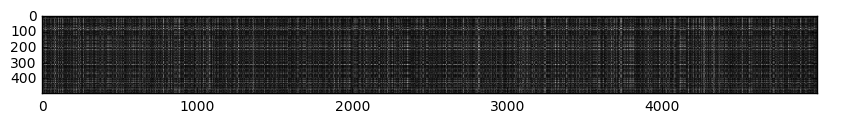

In [101]:
# We can visualize the distance matrix: each row is a single test example and
# its distances to training examples
plt.imshow(dists, interpolation='none')
plt.show()

**Inline Question #1:** Notice the structured patterns in the distance matrix, where some rows or columns are visible brighter. (Note that with the default color scheme black indicates low distances while white indicates high distances.)

- What in the data is the cause behind the distinctly bright rows?
- What causes the columns?

# 한글

세로 0-499가 테스트 이미지이고, 가로 0-4999가 학습이미지를 의미한다

검은색이 가까운 거리(=비슷한 이미지), 흰색이 먼거리라고 보면 된다

- 흰색이 많은 행은 무엇을 의미하는가?
- 흰색이 많은 열은 무엇을 의미하는가?

**Your Answer**: *fill this in.*
- 행에 흰색이 많은 건 이 테스트 이미지와 유사한 학습이미지가 없다는 것이다
- 열에 흰색이 많은 건 이 학습이미지가 독특해서 테스트 이미지들과 유사한게 없다는 것이다.


In [102]:
import numpy as np
a = np.array([1,2,3,1,2,1,1,1,3,2,2,1,4,4,4,4,4,4,4,4,4])
counts = np.bincount(a)
print (np.argmax(counts))

4


In [103]:
print(np.argsort([3,4,2,7]))  # 작은 값들의 인덱스부터 리턴해줌. 
# 즉, 2가 가장 작으니깐 2의 인덱스인 2
# 그다음은 3이니깐 인덱스인 0
# 4는 1, 7은 3이 된다. 따라서 [2,0,1,3]이 리턴된다

print(np.argsort([3,5,2,6])) # [(가장작은 2의 인덱스인)2, (3의 인덱스인) 0, (각각 5,6의 인덱스인) 1,3] 즉, [2,0,1,3]

[2 0 1 3]
[2 0 1 3]


In [104]:
# Now implement the function predict_labels and run the code below:
# We use k = 1 (which is Nearest Neighbor).

# 이제 각각의 테스트 이미지에 대한 학습 이미지들의 거리값을 알고 있다.
# k=1 일때의 예측을 해보자
y_test_pred = classifier.predict_labels(dists, k=1)
print(y_test_pred)

# Compute and print the fraction of correctly predicted examples
# 테스트 이미지 500개에 대해 예측이 맞은 개수와 정확도를 계산해보자

num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print ('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))

[0 0 0 0 1]
[0 0 0 0 0 0 0 0 0 1]
[0 0 0 0 0 0 0 0 1]
[0 0 0 0 0 0 0 0 1]
[0 0 0 0 1]
[0 0 0 0 1]
[0 0 0 1]
[0 0 1]
[0 0 0 0 0 1]
[0 0 0 0 0 0 0 0 1]
[0 0 1]
[0 0 0 0 0 0 0 0 1]
[0 0 0 0 0 1]
[0 0 0 0 0 0 0 1]
[0 0 1]
[0 0 1]
[0 0 0 0 0 1]
[0 0 0 1]
[0 1]
[0 0 0 0 1]
[0 0 1]
[1]
[1]
[0 0 0 0 0 0 1]
[0 0 1]
[0 0 0 0 1]
[0 0 1]
[0 0 0 0 0 0 0 1]
[0 0 1]
[0 0 0 0 0 0 1]
[0 0 0 0 0 0 1]
[0 0 1]
[0 0 0 0 1]
[0 0 0 0 0 0 1]
[0 0 0 0 0 0 0 0 1]
[0 0 0 0 0 0 0 1]
[0 0 1]
[0 0 0 0 0 0 0 0 1]
[0 0 0 0 1]
[0 0 1]
[0 0 0 0 0 0 0 0 1]
[0 0 0 0 0 0 1]
[0 0 1]
[0 0 0 0 1]
[0 0 0 0 0 0 0 0 0 1]
[1]
[0 0 0 0 0 1]
[1]
[0 0 0 0 1]
[0 0 1]
[0 0 0 0 0 0 0 1]
[0 0 0 0 0 0 0 0 1]
[0 0 0 0 1]
[0 0 0 1]
[0 0 0 0 0 0 0 0 1]
[0 0 0 0 0 0 0 0 1]
[0 0 0 0 0 1]
[1]
[1]
[0 0 0 0 1]
[0 0 0 0 1]
[0 0 0 0 0 0 1]
[0 0 0 0 0 0 1]
[0 0 0 1]
[0 0 0 1]
[0 0 1]
[0 0 0 0 0 0 0 0 1]
[0 0 0 0 0 0 0 0 1]
[0 0 0 1]
[0 0 0 0 0 0 0 0 0 1]
[0 0 1]
[0 0 0 0 1]
[0 0 0 0 0 0 0 0 1]
[1]
[0 0 0 0 1]
[0 0 0 0 1]
[0 0 0 0 0 0 1]
[0 0 0 1]


You should expect to see approximately `27%` accuracy. Now lets try out a larger `k`, say `k = 5`:

In [105]:
y_test_pred = classifier.predict_labels(dists, k=5)
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print ('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))

[0 0 0 0 3 0 2]
[1 0 0 0 0 0 0 0 3 1]
[0 0 0 0 0 1 0 0 4]
[1 0 1 0 0 0 0 0 3]
[0 0 1 0 3 1]
[0 0 1 0 1 1 2]
[0 0 1 1 1 0 2]
[0 0 2 0 1 0 1 1]
[0 0 3 0 0 1 0 0 1]
[0 1 0 0 0 0 0 0 3 1]
[2 0 1 0 0 1 0 0 1]
[0 0 0 0 1 0 0 1 2 1]
[0 0 0 1 2 2]
[0 0 0 0 0 1 3 1]
[0 0 1 0 2 0 0 0 2]
[0 0 2 0 1 0 0 0 2]
[0 0 1 1 0 3]
[0 0 1 1 2 0 0 0 1]
[0 1 0 0 0 0 0 0 3 1]
[0 0 2 1 1 0 0 1]
[0 0 3 0 1 0 1]
[5]
[5]
[0 0 2 0 2 0 1]
[1 0 2 0 2]
[0 0 1 0 4]
[0 0 2 0 1 0 2]
[0 0 1 0 2 0 0 2]
[0 0 1 0 1 0 1 1 0 1]
[0 0 2 1 1 0 1]
[2 0 1 0 0 0 2]
[0 0 4 0 1]
[0 0 1 0 3 1]
[0 0 0 2 0 1 2]
[0 0 1 0 0 0 0 0 3 1]
[0 1 0 0 1 0 1 1 1]
[0 0 2 0 2 0 1]
[3 0 0 0 0 0 0 0 2]
[0 0 2 0 1 0 1 0 1]
[1 0 1 0 1 1 0 0 1]
[0 0 1 0 0 0 0 0 4]
[0 0 1 1 0 0 3]
[1 0 1 0 1 0 0 1 1]
[0 0 0 0 3 0 1 0 1]
[2 0 0 0 1 0 0 0 1 1]
[2 0 1 0 0 0 0 0 2]
[0 1 0 1 0 3]
[2 0 1 0 0 0 0 0 2]
[0 0 0 0 5]
[0 0 3 0 2]
[1 0 0 0 0 0 0 1 2 1]
[1 0 0 0 1 0 0 0 3]
[0 0 0 0 2 0 2 0 1]
[0 0 2 1 1 1]
[1 0 0 0 0 0 0 0 4]
[1 0 0 0 1 0 0 0 3]
[0 0 0 0 2 3]
[1 1 0 1 0

In [112]:
# numpy.bincount() 테스트
# i번째 인덱스 위치의 값은 입력받은 nparray의 해당 i라는 정수의 갯수가 몇개인지를 리턴
print(np.bincount(np.array([0, 1, 1, 3, 2, 1, 7])))


[1 3 1 1 0 0 0 1]


You should expect to see a slightly better performance than with `k = 1`.

In [113]:
# Now lets speed up distance matrix computation by using partial vectorization
# with one loop. Implement the function compute_distances_one_loop and run the
# code below:

# 루프 하나로 partial vectorization 로 속도 빠르게 해서 
dists_one = classifier.compute_distances_one_loop(X_test)

# To ensure that our vectorized implementation is correct, we make sure that it
# agrees with the naive implementation. There are many ways to decide whether
# two matrices are similar; one of the simplest is the Frobenius norm. In case
# you haven't seen it before, the Frobenius norm of two matrices is the square
# root of the squared sum of differences of all elements; in other words, reshape
# the matrices into vectors and compute the Euclidean distance between them.

# 두가지 방식 : two-loop와 one-loop 방식으로 계산한 거리차이가 얼마나 나는지를 알아본다
print(dists[0])
print(dists_one[0])

difference = np.linalg.norm(dists - dists_one, ord='fro')
print ('Difference was: %f' % (difference, ))
if difference < 0.001:
  print ('Good! The distance matrices are the same')
else:
  print ('Uh-oh! The distance matrices are different')

[ 14469834.  17729119.  30294615. ...,  16061239.  17667570.  18959080.]
[ 318501.57929122  318501.57929122  318501.57929122 ...,  318501.57929122
  318501.57929122  318501.57929122]
Difference was: 43773339840.237663
Uh-oh! The distance matrices are different


In [114]:
# Now implement the fully vectorized version inside compute_distances_no_loops
# and run the code
dists_two = classifier.compute_distances_no_loops(X_test)

# check that the distance matrix agrees with the one we computed before:
difference = np.linalg.norm(dists - dists_two, ord='fro')
print ('Difference was: %f' % (difference, ))
if difference < 0.001:
  print ('Good! The distance matrices are the same')
else:
  print ('Uh-oh! The distance matrices are different')

Difference was: 44278155389.041145
Uh-oh! The distance matrices are different


In [115]:
# Let's compare how fast the implementations are
def time_function(f, *args):
  """
  Call a function f with args and return the time (in seconds) that it took to execute.
  """
  import time
  tic = time.time()
  f(*args)
  toc = time.time()
  return toc - tic

two_loop_time = time_function(classifier.compute_distances_two_loops, X_test)
print ('Two loop version took %f seconds' % two_loop_time)

one_loop_time = time_function(classifier.compute_distances_one_loop, X_test)
print ('One loop version took %f seconds' % one_loop_time)

no_loop_time = time_function(classifier.compute_distances_no_loops, X_test)
print ('No loop version took %f seconds' % no_loop_time)

# you should see significantly faster performance with the fully vectorized implementation

Two loop version took 292.124709 seconds
One loop version took 315.349037 seconds
No loop version took 0.218012 seconds


### Cross-validation

We have implemented the k-Nearest Neighbor classifier but we set the value k = 5 arbitrarily. We will now determine the best value of this hyperparameter with cross-validation.

In [ ]:
num_folds = 5
k_choices = [1, 3, 5, 8, 10, 12, 15, 20, 50, 100]

X_train_folds = []
y_train_folds = []
################################################################################
# TODO:                                                                        #
# Split up the training data into folds. After splitting, X_train_folds and    #
# y_train_folds should each be lists of length num_folds, where                #
# y_train_folds[i] is the label vector for the points in X_train_folds[i].     #
# Hint: Look up the numpy array_split function.                                #
################################################################################

# 학습 데이터를 5개로 나눔
X_train_folds = np.array(np.array_split(X_train, num_folds))
y_train_folds = np.array(np.array_split(y_train, num_folds))
################################################################################
#                                 END OF YOUR CODE                             #
################################################################################

# A dictionary holding the accuracies for different values of k that we find
# when running cross-validation. After running cross-validation,
# k_to_accuracies[k] should be a list of length num_folds giving the different
# accuracy values that we found when using that value of k.

# 저장용 딕셔너리
# 각각의 k 값에 대하여 5개의 fold 각각의 정확도(accuracy)를 담은 리스트를 쌍으로 가진다. (k값, 리스트)
k_to_accuracies = {}


################################################################################
# TODO:                                                                        #
# Perform k-fold cross validation to find the best value of k. For each        #
# possible value of k, run the k-nearest-neighbor algorithm num_folds times,   #
# where in each case you use all but one of the folds as training data and the #
# last fold as a validation set. Store the accuracies for all fold and all     #
# values of k in the k_to_accuracies dictionary.                               #
################################################################################
for k in k_choices:
    for n in xrange(num_folds):
        combinat = [x for x in xrange(num_folds) if x != n] 
        x_training_dat = np.concatenate(X_train_folds[combinat])
        y_training_dat = np.concatenate(y_train_folds[combinat])
        classifier_k = KNearestNeighbor()
        classifier_k.train(x_training_dat, y_training_dat)
        y_cross_validation_pred = classifier_k.predict_labels(X_train_folds[n], k)
        num_correct = np.sum(y_cross_validation_pred == y_train_folds[n])
        accuracy = float(num_correct) / num_test
        k_to_accuracies.setdefault(k, []).append(accuracy)
################################################################################
#                                 END OF YOUR CODE                             #
################################################################################

# Print out the computed accuracies
for k in sorted(k_to_accuracies):
    for accuracy in k_to_accuracies[k]:
        print ('k = %d, accuracy = %f' % (k, accuracy))

In [ ]:
# plot the raw observations
for k in k_choices:
  accuracies = k_to_accuracies[k]
  plt.scatter([k] * len(accuracies), accuracies)

# plot the trend line with error bars that correspond to standard deviation
accuracies_mean = np.array([np.mean(v) for k,v in sorted(k_to_accuracies.items())])
accuracies_std = np.array([np.std(v) for k,v in sorted(k_to_accuracies.items())])
plt.errorbar(k_choices, accuracies_mean, yerr=accuracies_std)
plt.title('Cross-validation on k')
plt.xlabel('k')
plt.ylabel('Cross-validation accuracy')
plt.show()

In [ ]:
# Based on the cross-validation results above, choose the best value for k,   
# retrain the classifier using all the training data, and test it on the test
# data. You should be able to get above 28% accuracy on the test data.
best_k = 1

classifier = KNearestNeighbor()
classifier.train(X_train, y_train)
y_test_pred = classifier.predict(X_test, k=best_k)

# Compute and display the accuracy
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print 'Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy)